In [1]:
# data stuff:
import pandas as pd
import numpy as np

# plotting stuff:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image
from IPython.core.display import display, HTML
from dtreeviz.trees import dtreeviz
import graphviz
import pydotplus

# stats stuff:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# modeling stuff:
import optuna
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

# silence!
import warnings
warnings.filterwarnings("ignore")

---
## 📊 Product Analytics:
Below we cover:

* Time Series Analysis





**📄 Dataset:** UCI Online Retail Data Set (https://archive.ics.uci.edu/ml/datasets/online+retail)

📚 See chapter 5 of _"Data Science for Marketing"_ by Hwang, page 154.

---

### Import Data and Preprocess:

In [2]:
data = pd.read_csv('data/Online Retail.csv')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/11 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France


#### Remove negative values from 'Quantity':
Negative values in the quantity column correspond to product returns/cancelled orders. We will remove these for our analysis.

In [3]:
# obtain a preview of data to remove:
data[data['Quantity']<0].value_counts()

InvoiceNo  StockCode  Description                         Quantity  InvoiceDate     UnitPrice  CustomerID  Country       
C543611    82483      WOOD 2 DRAWER CABINET WHITE FINISH  -1        2/10/11 14:38   4.95       17850.0     United Kingdom    4
C538341    22976      CIRCUS PARADE CHILDRENS EGG CUP     -12       12/10/10 14:03  1.25       15514.0     United Kingdom    3
           22730      ALARM CLOCK BAKELIKE IVORY          -1        12/10/10 14:03  3.75       15514.0     United Kingdom    3
           22725      ALARM CLOCK BAKELIKE CHOCOLATE      -1        12/10/10 14:03  3.75       15514.0     United Kingdom    3
C570556    22568      FELTCRAFT CUSHION OWL               -144      10/11/11 11:10  3.39       16029.0     United Kingdom    2
                                                                                                                            ..
C551388    22902      TOTE BAG I LOVE LONDON              -12       4/28/11 11:41   2.10       17874.0     United Ki

In [4]:
# filter and remove negatives:
data = data[data['Quantity'] > 0]
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/11 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France


#### Convert 'InvoiceDate' to datetime:

In [5]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

&nbsp;

---
### Time-Series Trends:
Next, we begin looking at the trends over time to see whether the business is growing/shrinking, etc...

&nbsp;

#### Get Monthly orders:

In [6]:
# set the index to the datetime column and resample to get monthly figures:
monthly_orders = data.set_index('InvoiceDate')['InvoiceNo'].resample('M').nunique()
monthly_orders

InvoiceDate
2010-12-31    1629
2011-01-31    1120
2011-02-28    1126
2011-03-31    1531
2011-04-30    1318
2011-05-31    1731
2011-06-30    1576
2011-07-31    1540
2011-08-31    1409
2011-09-30    1896
2011-10-31    2129
2011-11-30    2884
2011-12-31     839
Freq: M, Name: InvoiceNo, dtype: int64

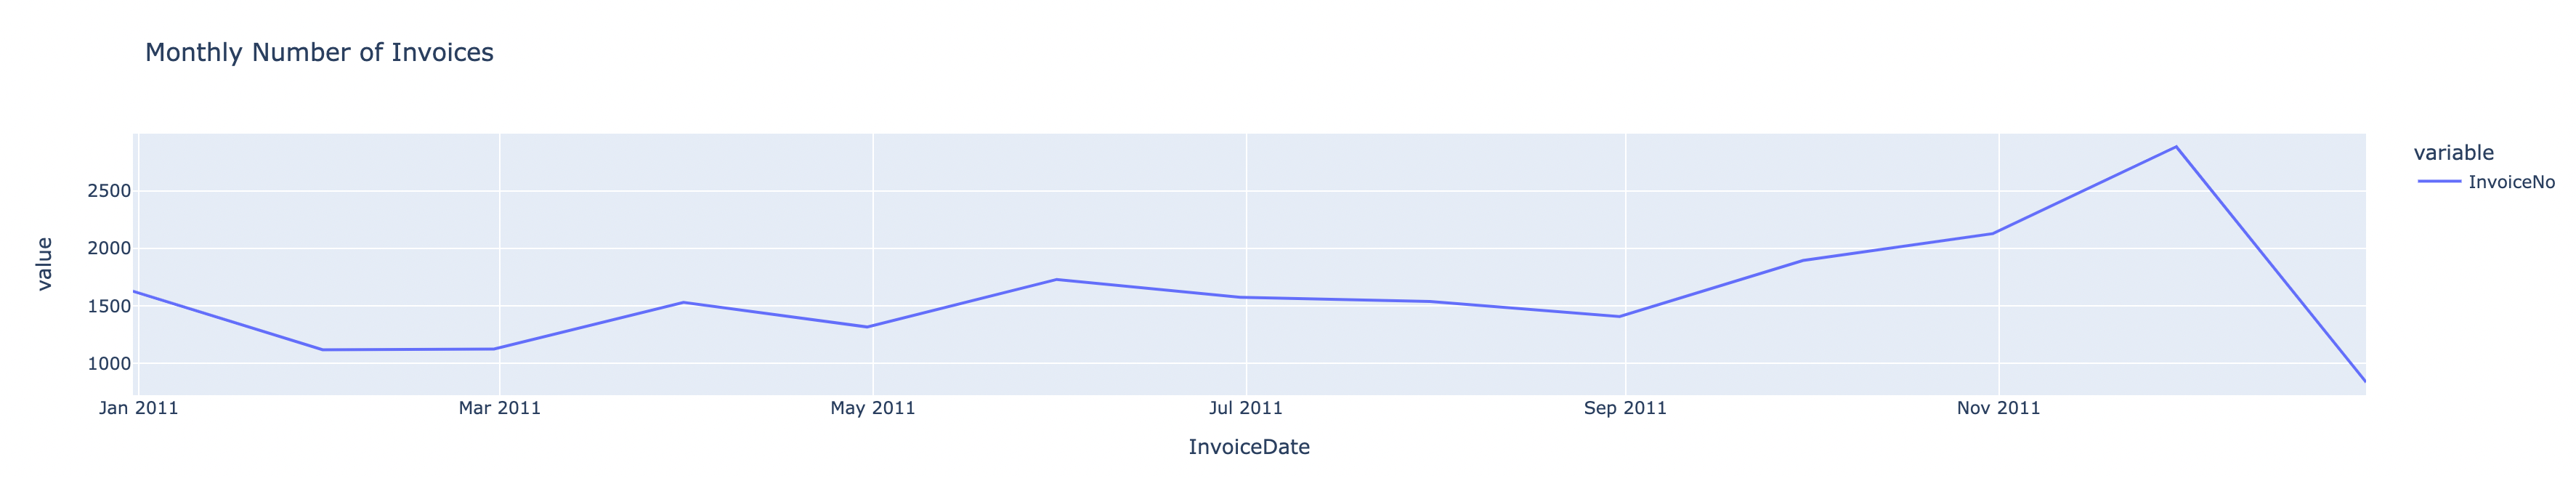

In [163]:
px.line(monthly_orders, title='Monthly Number of Invoices')
Image(filename='./images/ch5_1.png', width=1500)

The plot above looks reasonably normal except for the huge drop in the number of invoices for the month of December. This could be do to fewer orders, or just not enough data for the month.

&nbsp;

#### Perform Quality check on order dates:
Below we count the number of dates for orders for each month in the dataset to ensure we aren't being misled by the linechart above.  

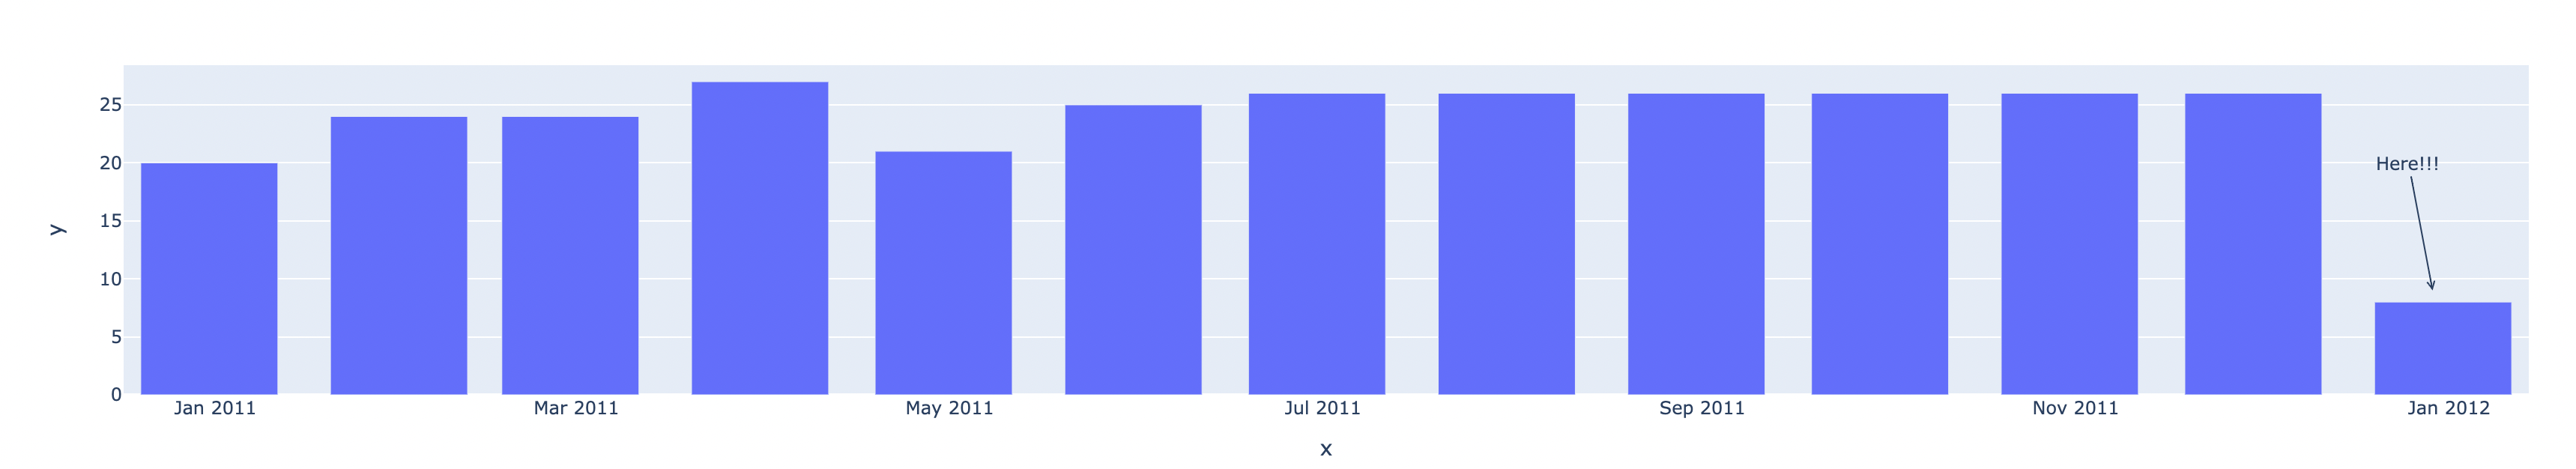

In [164]:
# create 
data['date_copy'] = data['InvoiceDate'].apply(lambda x: str(x)[0:10])
date_counts = data.set_index('InvoiceDate')['date_copy'].resample('M', convention='end').nunique()
rc_fig = px.bar(x=list(date_counts.index), y=date_counts)
rc_fig.add_annotation(
    xref="x domain",
    yref="y",
    x=0.96,
    y=9,
    text="Here!!!",
    # If axref is exactly the same as xref, then the text's position is
    # absolute and specified in the same coordinates as xref.
    axref="x domain",
    # The same is the case for yref and ayref, but here the coordinates are data
    # coordinates
    ayref="y",
    ax=0.95,
    ay=20,
    arrowhead=5,
)
rc_fig
Image(filename='./images/ch5_2.png', width=1500)

As we can see from the chart above, the month of December of 2011 only contains 8 days of data in total, which means our dataset is **right-censored**. We need to remove this month from our calculations if we want out estimates to be accurate.

&nbsp;

#### Remove right-censored data:

In [9]:
data = data[data['InvoiceDate']<'2011-12-01']
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date_copy
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
...,...,...,...,...,...,...,...,...,...
516364,579885,85034C,3 ROSE MORRIS BOXED CANDLES,4,2011-11-30 17:37:00,1.25,15444.0,United Kingdom,2011-11-30
516365,579885,21742,LARGE ROUND WICKER PLATTER,2,2011-11-30 17:37:00,5.95,15444.0,United Kingdom,2011-11-30
516366,579885,23084,RABBIT NIGHT LIGHT,6,2011-11-30 17:37:00,2.08,15444.0,United Kingdom,2011-11-30
516367,579885,21257,VICTORIAN SEWING BOX MEDIUM,1,2011-11-30 17:37:00,7.95,15444.0,United Kingdom,2011-11-30


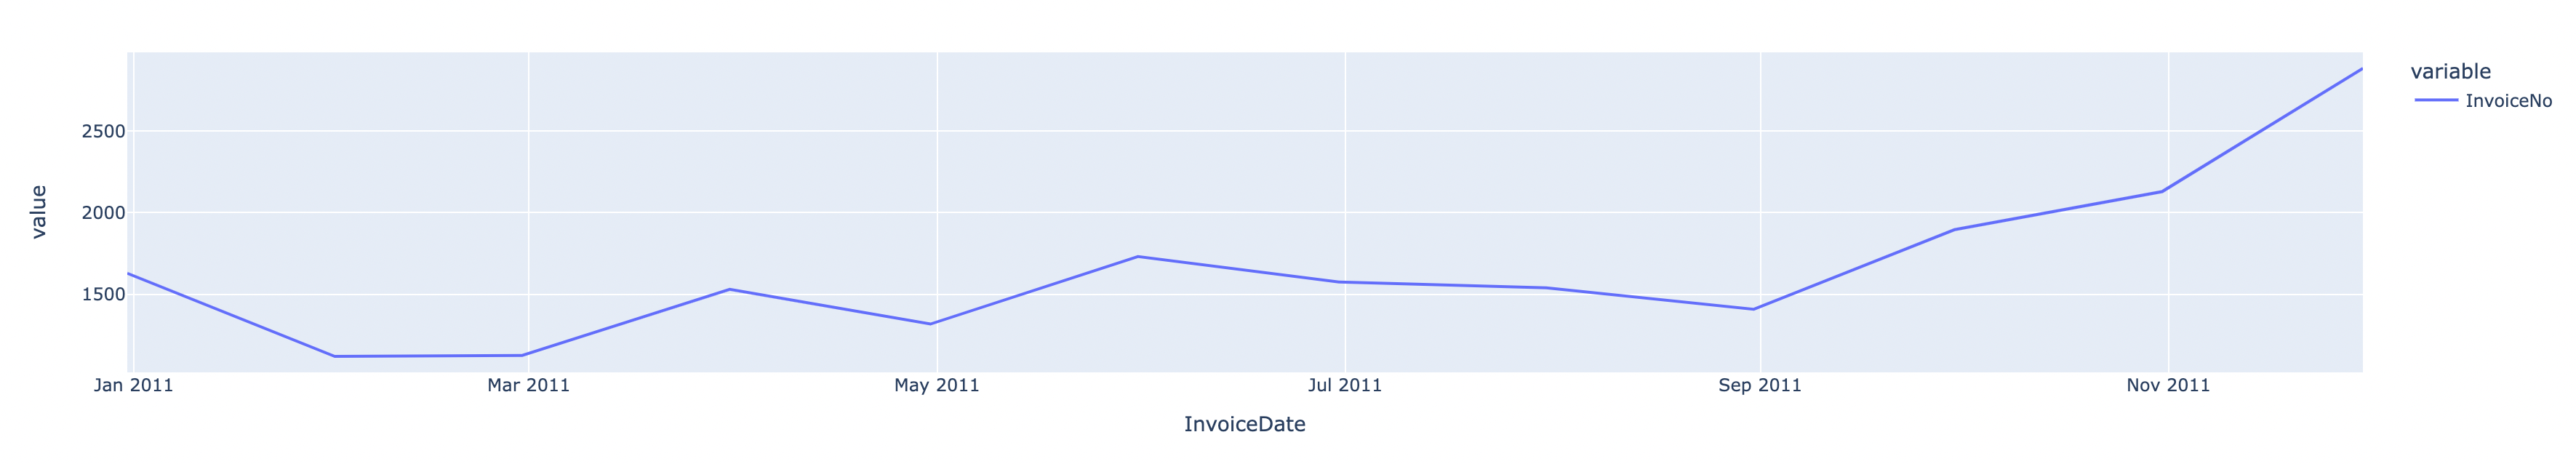

In [165]:
# resample and plot:
monthly_orders = data.set_index('InvoiceDate')['InvoiceNo'].resample('M').nunique()
px.line(monthly_orders)
Image(filename='./images/ch5_3.png', width=1500)

&nbsp;
#### Calculate Monthly Sales numbers:

In [11]:
data['Revenue'] = data['Quantity']*data['UnitPrice']
monthly_sales = data.set_index('InvoiceDate')['Revenue'].resample('M', convention='end').sum()
monthly_sales

InvoiceDate
2010-12-31     823746.140
2011-01-31     691364.560
2011-02-28     523631.890
2011-03-31     717639.360
2011-04-30     537808.621
2011-05-31     770536.020
2011-06-30     761739.900
2011-07-31     719221.191
2011-08-31     737014.260
2011-09-30    1058590.172
2011-10-31    1154979.300
2011-11-30    1509496.330
Freq: M, Name: Revenue, dtype: float64

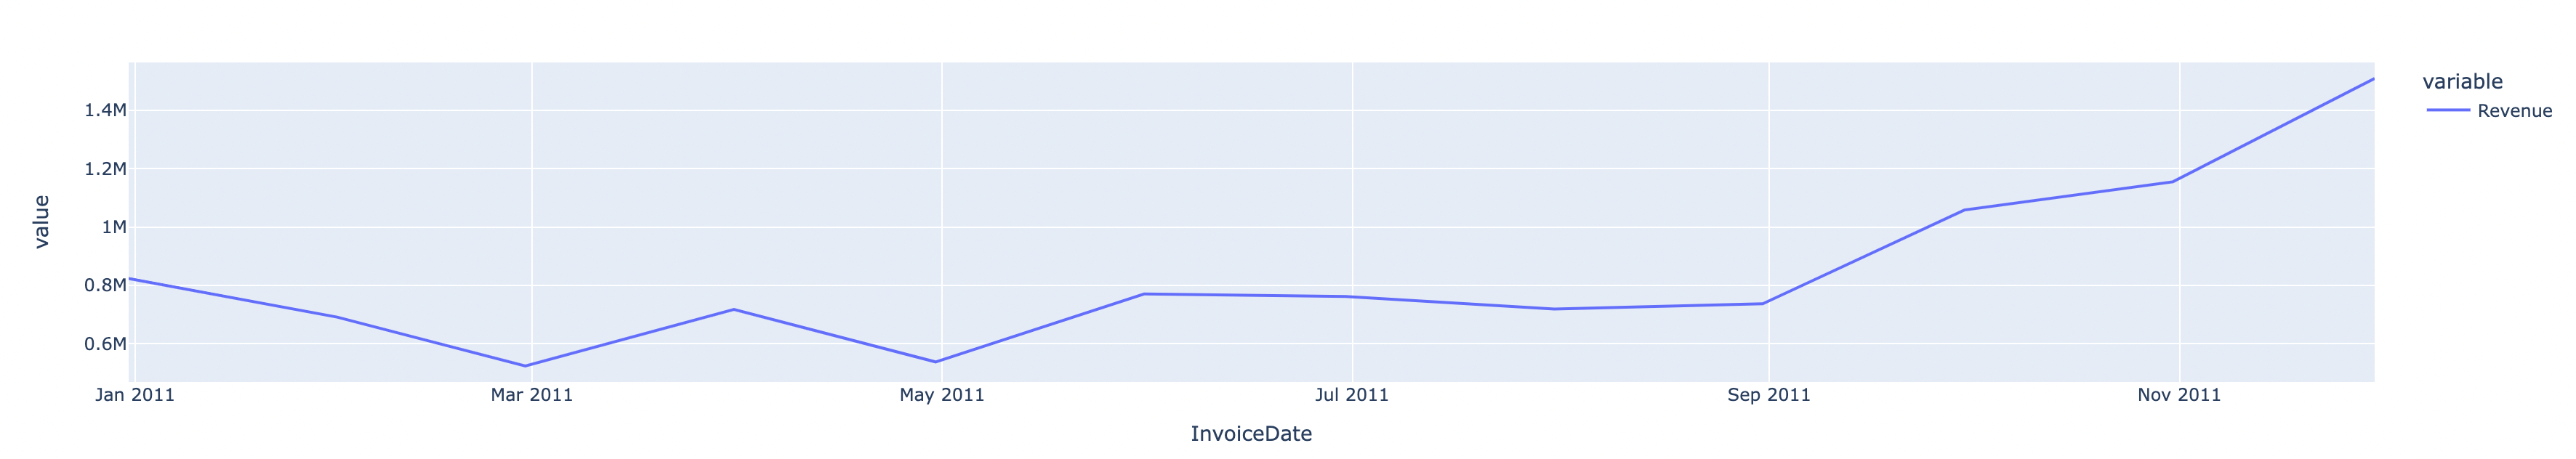

In [166]:
px.line(monthly_sales)
Image(filename='./images/ch5_4.png', width=1500)

&nbsp;
#### Find Repeat Customers (monthly):

In [13]:
# first, we need to combine sales into their respective invoices:
repeat_cust_df = data.groupby(['InvoiceNo', 'InvoiceDate']).agg({'Revenue': sum, 'CustomerID': max, 'Country': max}).reset_index()
repeat_cust_df

,InvoiceNo,InvoiceDate,Revenue,CustomerID,Country
0,536365,2010-12-01 08:26:00,139.12,17850.0,United Kingdom
1,536366,2010-12-01 08:28:00,22.20,17850.0,United Kingdom
2,536367,2010-12-01 08:34:00,278.73,13047.0,United Kingdom
3,536368,2010-12-01 08:34:00,70.05,13047.0,United Kingdom
4,536369,2010-12-01 08:35:00,17.85,13047.0,United Kingdom
...,...,...,...,...,...
19926,579881,2011-11-30 17:22:00,905.52,12429.0,Denmark
19927,579885,2011-11-30 17:37:00,1075.36,15444.0,United Kingdom
19928,A563185,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
19929,A563186,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom


In [14]:
# create year-month variable to make it easy to group by:
repeat_cust_df['year_month'] = repeat_cust_df['InvoiceDate'].apply(lambda x: str(x)[0:7])

# group by year-month and get the value counts (number of orders for each customer ID for each month):
repeat_custs = repeat_cust_df.groupby('year_month')['CustomerID'].value_counts().to_frame().rename(columns={'CustomerID': 'count'})

# get the count of all the unique customers with more than one order per month (repeat customer)
repeat_custs = repeat_custs[repeat_custs['count']>1].reset_index()
repeat_custs = repeat_custs.groupby('year_month')['CustomerID'].nunique()
repeat_custs

# alternative:
# repeat_custs = repeat_cust_df.set_index('InvoiceDate').groupby([
#     pd.Grouper(freq='M'), 'CustomerID'
# ]).filter(lambda x: len(x) > 1).resample('M').nunique()['CustomerID']

year_month
2010-12    263
2011-01    153
2011-02    153
2011-03    203
2011-04    170
2011-05    281
2011-06    220
2011-07    227
2011-08    198
2011-09    272
2011-10    324
2011-11    541
Name: CustomerID, dtype: int64

&nbsp;
#### Find total unique customers (monthly):

In [15]:
unique_customers = repeat_cust_df.groupby('year_month')['CustomerID'].nunique()
unique_customers

year_month
2010-12     885
2011-01     741
2011-02     758
2011-03     974
2011-04     856
2011-05    1056
2011-06     991
2011-07     949
2011-08     935
2011-09    1266
2011-10    1364
2011-11    1665
Name: CustomerID, dtype: int64

&nbsp;
#### Find percent of repeat customers (monthly):

In [25]:
repeat_customers_percent = np.round(repeat_custs / unique_customers*100, 2)
repeat_customers_percent

year_month
2010-12    29.72
2011-01    20.65
2011-02    20.18
2011-03    20.84
2011-04    19.86
2011-05    26.61
2011-06    22.20
2011-07    23.92
2011-08    21.18
2011-09    21.48
2011-10    23.75
2011-11    32.49
Name: CustomerID, dtype: float64

&nbsp;
#### Plot Repeat Customers vs. All:

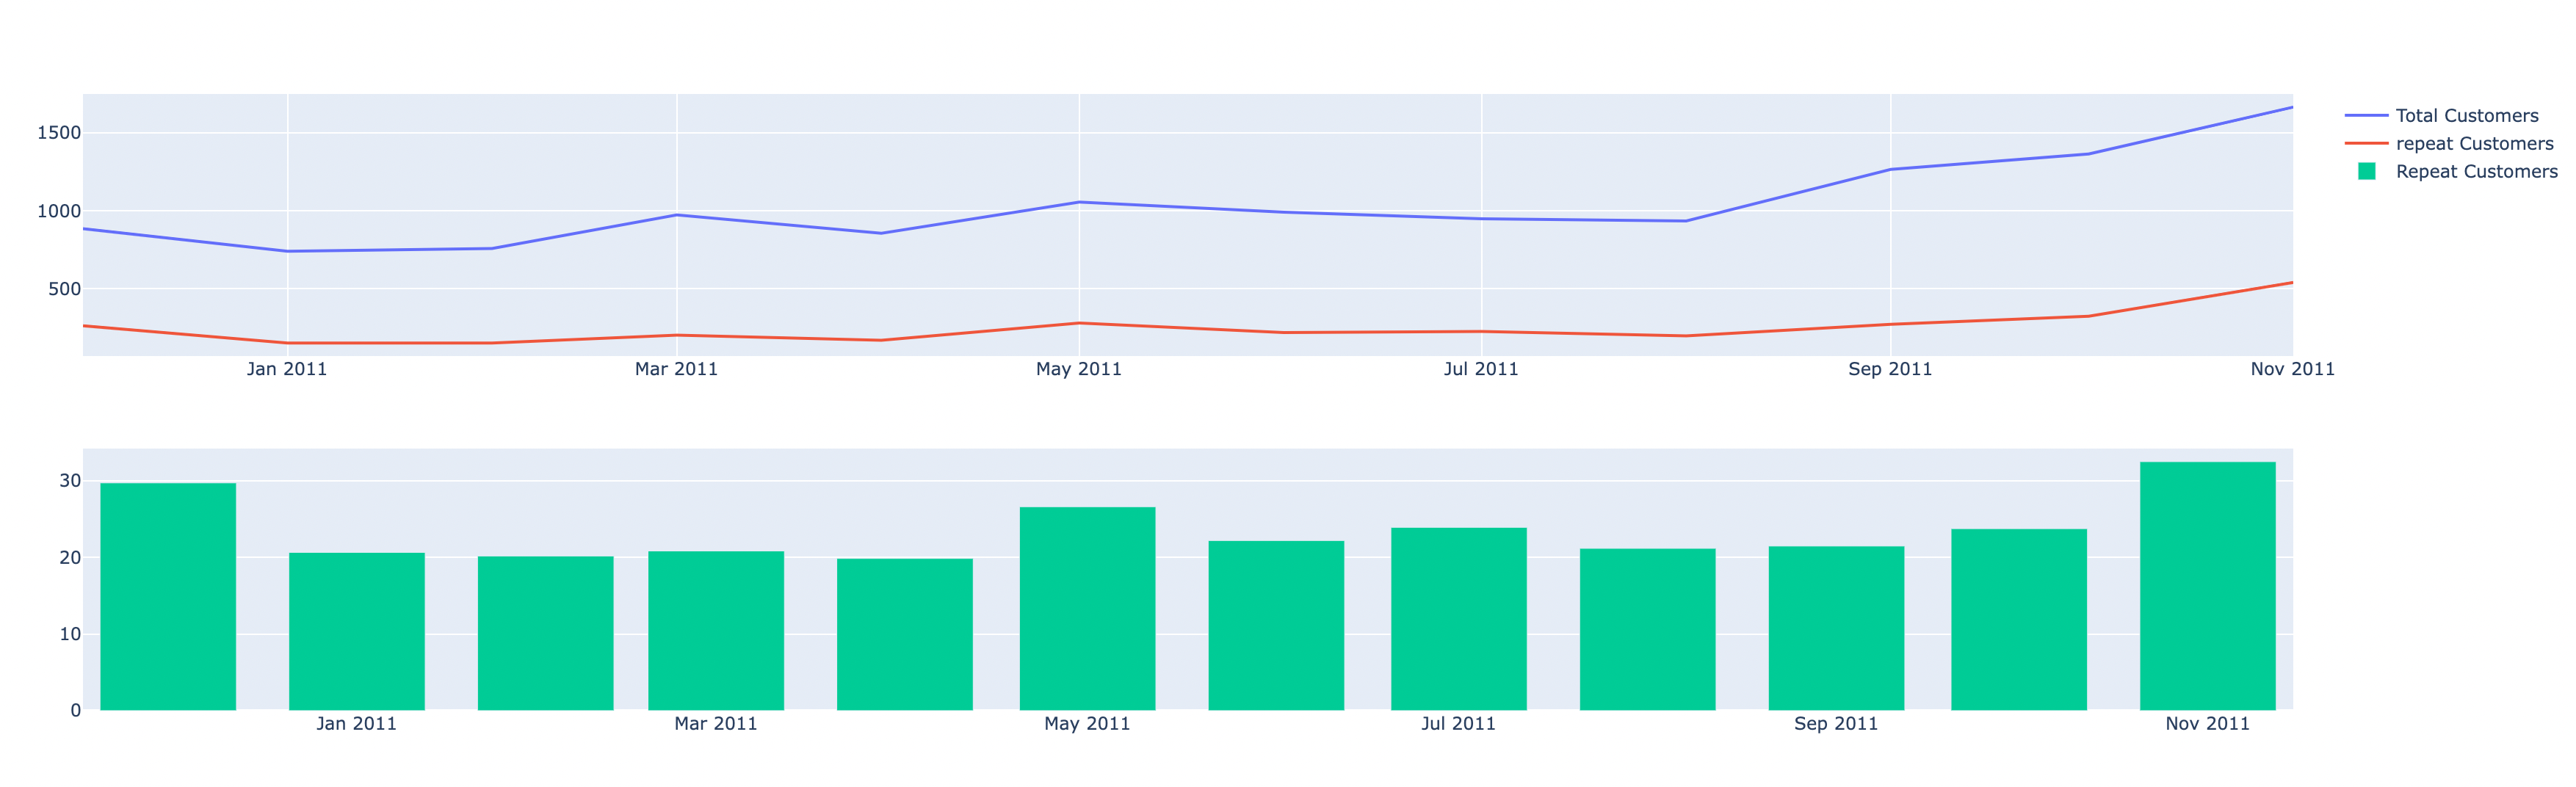

In [168]:
# customers_fig = make_subplots(specs=[[{"secondary_y": True}]])
# customers_fig.add_trace(go.Bar(x=repeat_customers_percent.index, y=repeat_customers_percent, name='Repeat Customers %'), secondary_y=True)
# customers_fig.add_trace(go.Scatter(x=unique_customers.index, y=unique_customers, mode='lines', name='Total Customers'), secondary_y=False)
# customers_fig.add_trace(go.Scatter(x=repeat_custs.index, y=repeat_custs, mode='lines', name='repeat Customers'), secondary_y=False)
# customers_fig.update_layout(height=600, width=1800)
# customers_fig

customers_fig = make_subplots(rows=2, cols=1)
customers_fig.add_trace(go.Scatter(x=unique_customers.index, y=unique_customers, mode='lines', name='Total Customers'), row=1, col=1)
customers_fig.add_trace(go.Scatter(x=repeat_custs.index, y=repeat_custs, mode='lines', name='repeat Customers'), row=1, col=1)
customers_fig.add_trace(go.Bar(x=repeat_customers_percent.index, y=repeat_customers_percent, name='Repeat Customers %'), row=2, col=1)
customers_fig.update_layout(height=600, width=1800)
customers_fig
Image(filename='./images/ch5_5.png', width=1700)

&nbsp;
#### Item Trends over time:

In [153]:
# group by date and stockcode and get total sum of quantity sold:
items_df = data.groupby(['InvoiceDate', 'Description'])['Quantity'].sum().reset_index()
items_df['year_month'] = items_df['InvoiceDate'].apply(lambda x: str(x)[0:7])

In [154]:
# group by year-month to facilitate calculations.
# drop the first level of the multi-index (stock-code) to add to df: 
items_df = items_df.groupby(['year_month', 'Description'])['Quantity'].sum().to_frame().reset_index(level=1)

In [155]:
items_df

,Description,Quantity
year_month,,
2010-12,4 PURPLE FLOCK DINNER CANDLES,16
2010-12,OVAL WALL MIRROR DIAMANTE,22
2010-12,SET 2 TEA TOWELS I LOVE LONDON,310
2010-12,*Boombox Ipod Classic,1
2010-12,*USB Office Mirror Ball,2
...,...,...
2011-11,dotcom,20
2011-11,dotcom adjust,10
2011-11,dotcomstock,4


In [156]:
# get the most sold items in the month of november 2011:
november_best_sellers = items_df.loc['2011-11'].sort_values(by='Quantity', ascending=False)
november_best_sellers

,Description,Quantity
year_month,,
2011-11,RABBIT NIGHT LIGHT,14954
2011-11,ASSTD DESIGN 3D PAPER STICKERS,12551
2011-11,POPCORN HOLDER,12460
2011-11,PAPER CHAIN KIT 50'S CHRISTMAS,7908
2011-11,JUMBO BAG RED RETROSPOT,5909
...,...,...
2011-11,SET OF 16 VINTAGE RED CUTLERY,1
2011-11,"FLOWER GLASS GARLAND NECKL.36""BLUE",1
2011-11,FLOWER SHOP DESIGN MUG,1


In [157]:
# get the top five items:
top_five = list(november_best_sellers['Description'][:5].values)
top_five

['RABBIT NIGHT LIGHT',
 'ASSTD DESIGN 3D PAPER STICKERS',
 'POPCORN HOLDER',
 "PAPER CHAIN KIT 50'S CHRISTMAS ",
 'JUMBO BAG RED RETROSPOT']

&nbsp;
#### Track the performance of the top five across time:

In [159]:
best_sellers_df = data[data['Description'].isin(top_five)]
best_sellers_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date_copy,Revenue,year_month
46,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 09:00:00,2.55,13748.0,United Kingdom,2010-12-01,204.00,2010-12
122,536381,22086,PAPER CHAIN KIT 50'S CHRISTMAS,4,2010-12-01 09:41:00,2.95,15311.0,United Kingdom,2010-12-01,11.80,2010-12
177,536386,85099B,JUMBO BAG RED RETROSPOT,100,2010-12-01 09:57:00,1.65,16029.0,United Kingdom,2010-12-01,165.00,2010-12
234,536390,85099B,JUMBO BAG RED RETROSPOT,100,2010-12-01 10:19:00,1.65,17511.0,United Kingdom,2010-12-01,165.00,2010-12
382,536402,22086,PAPER CHAIN KIT 50'S CHRISTMAS,40,2010-12-01 11:22:00,2.55,15513.0,United Kingdom,2010-12-01,102.00,2010-12
...,...,...,...,...,...,...,...,...,...,...,...
516095,579867,23084,RABBIT NIGHT LIGHT,12,2011-11-30 16:41:00,2.08,16265.0,United Kingdom,2011-11-30,24.96,2011-11
516110,579867,22086,PAPER CHAIN KIT 50'S CHRISTMAS,6,2011-11-30 16:41:00,2.95,16265.0,United Kingdom,2011-11-30,17.70,2011-11
516140,579870,23084,RABBIT NIGHT LIGHT,24,2011-11-30 16:47:00,1.79,12437.0,France,2011-11-30,42.96,2011-11
516209,579881,23084,RABBIT NIGHT LIGHT,12,2011-11-30 17:22:00,2.08,12429.0,Denmark,2011-11-30,24.96,2011-11


In [160]:
best_sellers_df = best_sellers_df.groupby(['year_month', 'Description'])['Quantity'].sum().to_frame().reset_index()
best_sellers_df.head()

,year_month,Description,Quantity
0,2010-12,ASSTD DESIGN 3D PAPER STICKERS,366
1,2010-12,JUMBO BAG RED RETROSPOT,2152
2,2010-12,PAPER CHAIN KIT 50'S CHRISTMAS,2460
3,2011-01,ASSTD DESIGN 3D PAPER STICKERS,480
4,2011-01,JUMBO BAG RED RETROSPOT,2747


In [161]:
# pivot the df to get the items in the columns:
best_seller_pt = best_sellers_df.pivot_table(index='year_month', columns='Description', values='Quantity').fillna(0)
best_seller_pt

Description,ASSTD DESIGN 3D PAPER STICKERS,JUMBO BAG RED RETROSPOT,PAPER CHAIN KIT 50'S CHRISTMAS,POPCORN HOLDER,RABBIT NIGHT LIGHT
year_month,,,,,
2010-12,366.0,2152.0,2460.0,0.0,0.0
2011-01,480.0,2747.0,24.0,0.0,0.0
2011-02,66.0,3080.0,5.0,0.0,0.0
2011-03,60.0,5282.0,87.0,0.0,0.0
2011-04,1.0,2456.0,13.0,0.0,0.0
2011-05,0.0,3621.0,17.0,0.0,1131.0
2011-06,4.0,3682.0,344.0,968.0,1713.0
2011-07,2.0,3129.0,383.0,1840.0,294.0
2011-08,72.0,5502.0,490.0,5321.0,1847.0


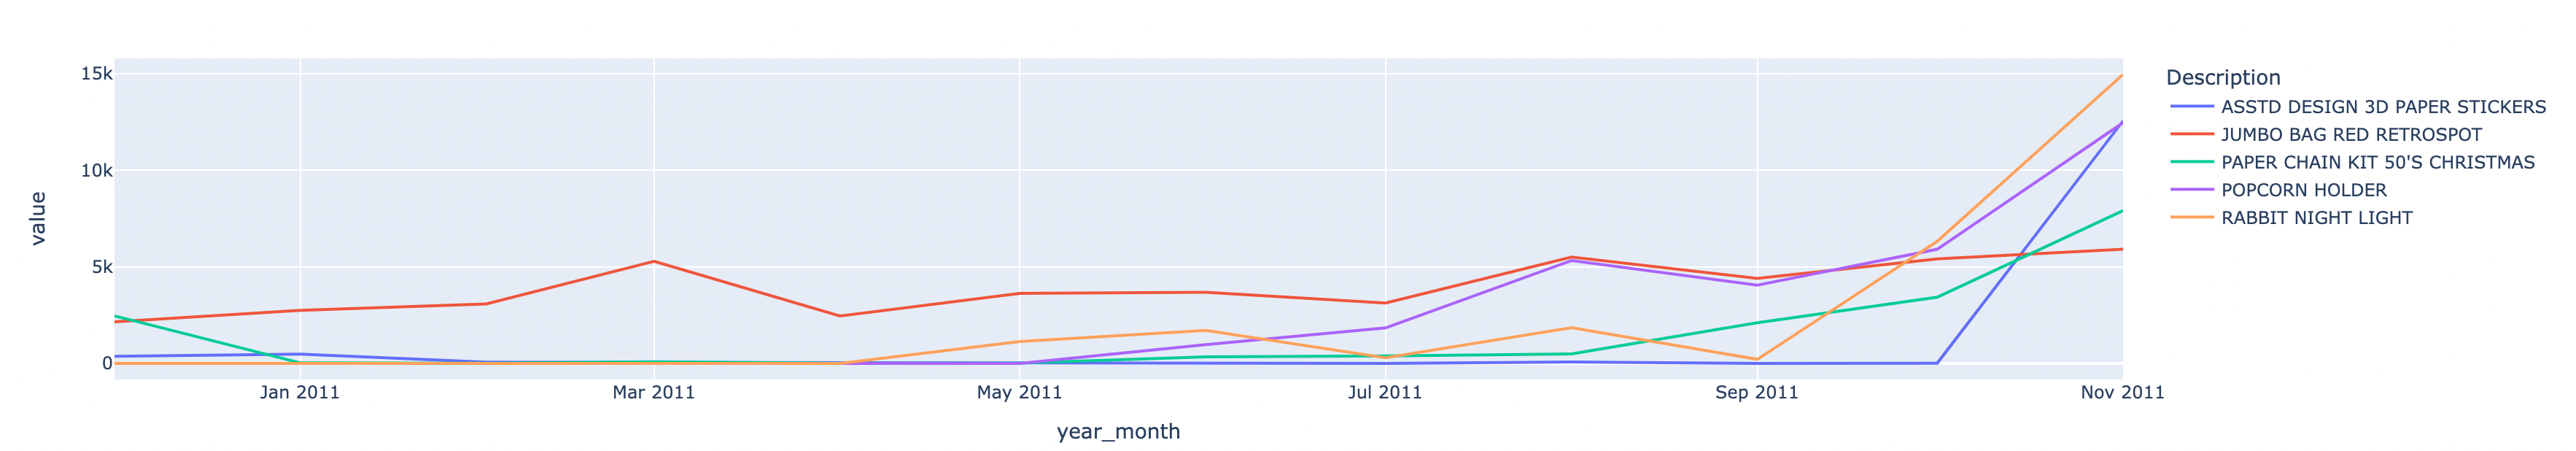

In [170]:
px.line(best_seller_pt)
Image(filename='./images/ch5_6.png', width=1700)